# Settings

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
labeled_comments = pd.read_csv('/Data/labeled_comments.csv')
ori_comments = pd.read_csv('Data/ori_comments.csv')
labeled_comments

In [ ]:
import os

aug_comments = []
dir_name = "Data/"

unlister = lambda x: x[0]

for file in os.listdir(dir_name):
    if "aug" in file:
      dataset = list(map(unlister, list(map(eval, list(pd.read_csv(dir_name + file)["comment"])))))
      aug_comments.extend(dataset)

# Preprocessing

In [ ]:
!pip install transformers
!pip install sentencepiece
import sentencepiece
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('sismetanin/xlm_roberta_base-ru-sentiment-rusentiment', do_lower_case=True)

In [ ]:
tokenizer

In [ ]:
class Tokenizer:
    def __init__(self,
                 tokenizer,
                 add_special_tokens=True,
                 max_length=60,
                 truncation=True,
                 pad_to_max_length=True,
                 return_attention_mask=True,
                 return_tensors='pt'):

        self.tokenizer = tokenizer
        self.add_special_tokens = add_special_tokens
        self.max_length = max_length
        self.truncation = truncation
        self.pad_to_max_length = pad_to_max_length
        self.return_attention_mask = return_attention_mask
        self.return_tensors = return_tensors

    def tokenize(self, text: list) -> tuple:
        input_ids = []
        attention_masks = []
        for row in text:
            encoded_dict = self.tokenizer.encode_plus(
                row,
                add_special_tokens=self.add_special_tokens,
                max_length=self.max_length,
                truncation=self.truncation,
                pad_to_max_length=self.pad_to_max_length,
                return_attention_mask=self.return_attention_mask,
                return_tensors=self.return_tensors,
            )

            input_ids.append(encoded_dict['input_ids'])

            attention_masks.append(encoded_dict['attention_mask'])
        return input_ids, attention_masks

In [ ]:
preprocessor = Tokenizer(tokenizer=tokenizer)

In [ ]:
from collections import Counter
#changing labels
labels = labeled_comments["is_aggressive"]
print(labels.value_counts())
Counter(labels)

In [ ]:
labeled_input_ids, labeled_attention_masks = preprocessor.tokenize(list(labeled_comments.comment))

labeled_input_ids = torch.cat(labeled_input_ids, dim=0)
labeled_attention_masks = torch.cat(labeled_attention_masks, dim=0)
labels = torch.tensor(list(map(int, labels.tolist())))

In [ ]:
ori_input_ids, ori_attention_masks = preprocessor.tokenize(list(ori_comments.comment))

ori_input_ids = torch.cat(ori_input_ids, dim=0)
ori_attention_masks = torch.cat(ori_attention_masks, dim=0)

In [ ]:
aug_input_ids, aug_attention_masks = preprocessor.tokenize(list(aug_comments))

aug_input_ids = torch.cat(aug_input_ids, dim=0)
aug_attention_masks = torch.cat(aug_attention_masks, dim=0)

In [ ]:
import os
import torch
from torchvision import transforms
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Metrics

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

In [ ]:
def flat_accuracy(labels, preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(labels_flat == pred_flat) / len(labels_flat)

In [ ]:
def flat_roc_auc(labels, preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return roc_auc_score(labels_flat, pred_flat)

In [ ]:
def proba_roc_auc(labels, preds):
    softmax = torch.nn.Sigmoid()
    preds_softmax = softmax(torch.from_numpy(preds)).numpy()
    labels_flat = labels.flatten()
    print(labels_flat.shape, preds_softmax.shape)
    return roc_auc_score(labels_flat, preds_softmax[:, 1])

In [ ]:
def flat_f1(labels, preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

In [ ]:
def flat_balanced_accuracy(labels, preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return balanced_accuracy_score(labels_flat, pred_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


https://www.youtube.com/watch?v=-u8Mi57BDIY </br>
https://arxiv.org/pdf/1904.12848.pdf


# Models

In [ ]:
from transformers import AutoModel, AutoModelForSequenceClassification, BertForSequenceClassification, AutoConfig
import torch.nn as nn
from torch.optim import AdamW

## XLM-Roberta base

In [ ]:
class XLMRobertaBaseClassifier(nn.Module):
    def __init__(self):
        super(XLMRobertaBaseClassifier, self).__init__()
        self.base_model = AutoModel.from_pretrained('sismetanin/xlm_roberta_base-ru-sentiment-rusentiment')
        self.Linear = nn.Linear(768, 2)
        
    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.base_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask).pooler_output
        outputs = self.Linear(outputs)

        return outputs


#UDA

To utilize unlabeld data we are going to perform an Unsupervised data augmentation technique. </br>
In this soluton </br>
` labeled` objects are samples form the training labeled set</br>
`ori` objects are original unlabeled samples</br>
`aug` objects are back translated unlabeled samples</br>

</br>
[Original pytorch UDA repository](https://github.com/SanghunYun/UDA_pytorch)



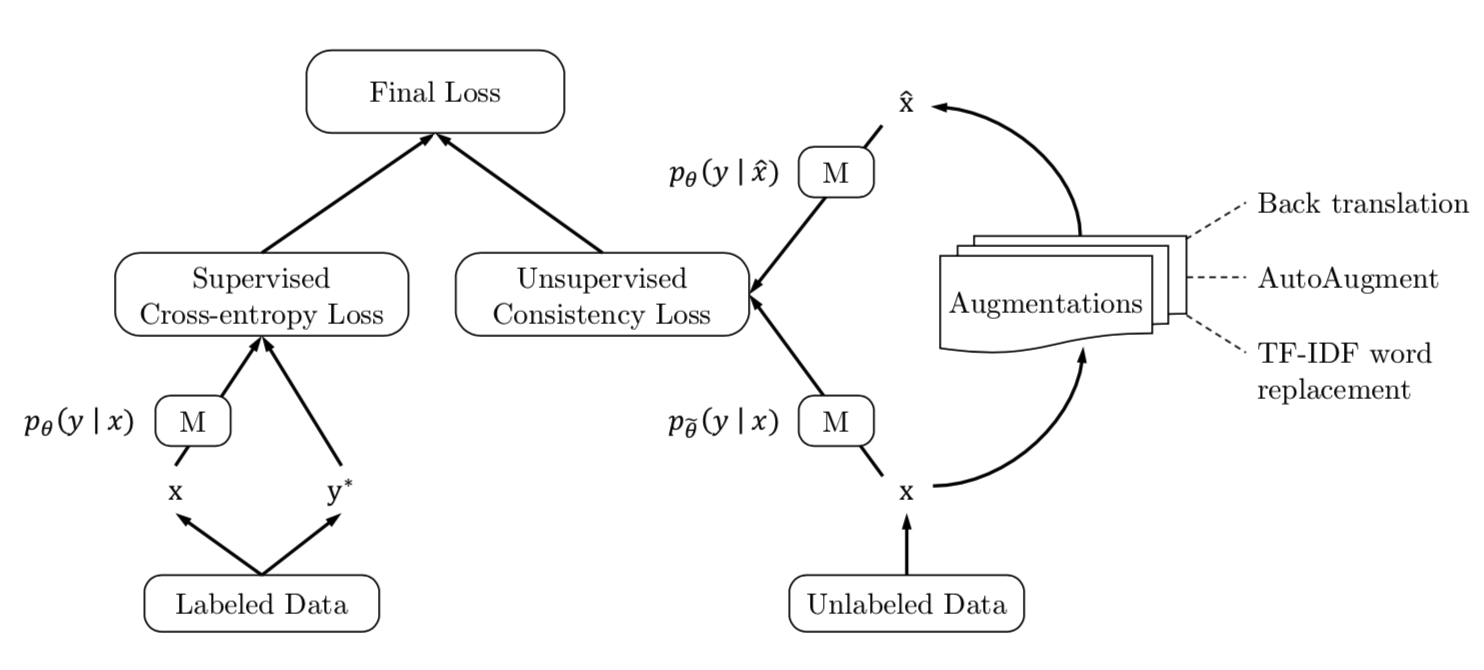

In [ ]:
class UnsupervisesConsistencyLoss(object):
    def __init__(self, uda_coef, total_steps, softmax_temp, uda_confidence_thresh): 
        self.supervised_loss = nn.CrossEntropyLoss(reduction='none')
        self.unsupervised_loss = nn.KLDivLoss(reduction='none')

        self.uda_coef = uda_coef
        self.total_steps = total_steps
        self.softmax_temp = softmax_temp
        self.uda_confidence_thresh = uda_confidence_thresh

        self.softmax = nn.Softmax(dim=-1)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    
    def __call__(self, logits: torch.Tensor, target: torch.Tensor, ori_preds: torch.Tensor, global_step: int) -> torch.Tensor:
        sup_size = target.shape[0]  
        
        sup_loss = self.supervised_loss(logits[:sup_size], target)  # shape : train_batch_size

        ori_prob = self.softmax(ori_preds)

        if self.uda_confidence_thresh != -1:
            unsup_loss_mask = torch.max(ori_prob, dim=-1)[0] > self.uda_confidence_thresh
            unsup_loss_mask = unsup_loss_mask.type(torch.float32)
        else:
            unsup_loss_mask = torch.ones(len(logits) - sup_size, dtype=torch.float32)
        unsup_loss_mask = unsup_loss_mask.to(device)

        softmax_temp = self.softmax_temp if self.softmax_temp > 0 else 1.
        aug_log_prob = self.log_softmax(logits[sup_size:] / softmax_temp)

        unsup_loss = torch.sum(self.unsupervised_loss(aug_log_prob, ori_prob), dim=-1)
        unsup_loss = torch.sum(unsup_loss * unsup_loss_mask, dim=-1) / torch.max(torch.sum(unsup_loss_mask, dim=-1))
        final_loss = sup_loss + self.uda_coef * unsup_loss
        return  final_loss


In [ ]:
from math import ceil
from transformers import get_linear_schedule_with_warmup
from itertools import cycle


class SemiSupervisedModel(object):
    def __init__(self, model, optimizer, loss, device, verbose):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

    def fit(self,  sup_dataset, labels, ori_unsup_dataset, uda_unsup_dataset, loss, epochs, sup_batch_size):
        self.loss = loss
        n_sup_batches = ceil(len(sup_dataset) / sup_batch_size)
        unsup_batch_size = int(len(ori_unsup_dataset) / n_sup_batches)

        self.sup_batch_size = sup_batch_size
        sup_dataloader = torch.utils.data.DataLoader(
                    labeled_dataset, 
                    batch_size=sup_batch_size)
        
        ori_unsup_dataloader = torch.utils.data.DataLoader(
                    ori_unsup_dataset, 
                    batch_size=unsup_batch_size)
        
        uda_unsup_dataloader = torch.utils.data.DataLoader(
                    uda_unsup_dataset, 
                    batch_size=unsup_batch_size)
        print(len(sup_dataloader), len(ori_unsup_dataloader))

        total_steps = len(sup_dataloader) * epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer,
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

        for epoch_i in range(1, epochs + 1):
            avg_train_loss = self.train_epoch(sup_dataloader, labels, ori_unsup_dataloader, uda_unsup_dataloader)
            print(f"Epoch {epoch_i}: {avg_train_loss}")
            self.save_model(f"base_models/uda_xlm_roberta_base_{epoch_i}_epochs.h5")

    def train_epoch(self, sup_dataloader, labels, ori_unsup_dataloader, uda_unsup_dataloader):
        total_train_loss = 0
        self.model.train()
        for step, batch in enumerate(zip(cycle(sup_dataloader), ori_unsup_dataloader, uda_unsup_dataloader)):

            if step % self.verbose == 0 and not step == 0:
                print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(sup_dataloader)))

            input_ids = batch[0][0].to(self.device)
            attention_mask = batch[0][1].to(self.device)
            labels = batch[0][2].to(self.device)

            ori_input_ids = batch[1][0].to(self.device)
            ori_attention_mask = batch[1][1].to(self.device)

            uda_input_ids = batch[2][0].to(self.device)
            uda_attention_mask = batch[2][1].to(self.device)

            input_ids = torch.cat((input_ids, uda_input_ids), dim=0)
            input_mask = torch.cat((attention_mask, uda_attention_mask), dim=0)

            self.optimizer.zero_grad()
            logits = self.predict(input_ids, attention_mask=input_mask, train=True)
            ori_logits = self.predict(input_ids=ori_input_ids, attention_mask=ori_attention_mask, train=False)

            loss = self.loss(logits, labels, ori_logits, step)

            total_train_loss += loss.item()
            loss.backward()

            nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

        avg_train_loss = total_train_loss / len(labeled_dataset)
        return avg_train_loss
    
    def save_model(self, name):
        torch.save(self.model.state_dict(), name)

    def predict(self, input_ids, attention_mask, train):
        if train:
            self.model.train()
        else:
            self.model.eval()

        predictions = []
        pred_dataset = TensorDataset(input_ids, attention_mask)
        pred_dataloader = torch.utils.data.DataLoader(
                    pred_dataset, 
                    batch_size=self.sup_batch_size)
        # print(len(pred_dataloader), self.sup_batch_size, self.sup_batch_size * len(pred_dataloader))

        for step, batch in enumerate(pred_dataloader):
            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)

            if train:
                    output = self.model(b_input_ids,
                                        token_type_ids=None,
                                        attention_mask=b_input_mask)
            else:
                with torch.no_grad():
                    output = self.model(b_input_ids,
                                        token_type_ids=None,
                                        attention_mask=b_input_mask)
                
            predictions.append(output)
        preds = torch.cat(predictions, dim=0)
        return preds

In [ ]:
base_model = XLMRobertaBaseClassifier()
base_model.to(device)
print()

In [ ]:
labeled_dataset = TensorDataset(labeled_input_ids, labeled_attention_masks, labels)
ori_dataset = TensorDataset(ori_input_ids, ori_attention_masks)
aug_dataset = TensorDataset(aug_input_ids, aug_attention_masks)

In [ ]:
optimizer = AdamW(base_model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )
batch_size = 1
loss = UnsupervisesConsistencyLoss(10, total_steps=ceil(len(labeled_dataset) /  batch_size), softmax_temp=0.9, uda_confidence_thresh=-1)
device = device
verbose = 50

In [ ]:
model = SemiSupervisedModel(base_model, optimizer, loss, device, verbose)
model.fit(sup_dataset=labeled_dataset, labels=labels, ori_unsup_dataset=ori_dataset, uda_unsup_dataset=aug_dataset, loss=loss, epochs=3, sup_batch_size=batch_size)

# Test Prediction

In [ ]:
import pandas as pd
test = pd.read_csv('../Data_rus/labled_test_data.csv', index_col=0, sep="\t")

## Tokenize

In [ ]:
!pip install transformers
!pip install sentencepiece
import sentencepiece
from transformers import AutoTokenizer
import string

tokenizer = AutoTokenizer.from_pretrained('sismetanin/xlm_roberta_base-ru-sentiment-rusentiment', do_lower_case=True)

In [ ]:
import string
punktuation = list(string.punctuation)
custom_punkt = ["\t", ")", "("]
punktuation.extend(custom_punkt)

end_punktuation = ["!", ".", "?", "\n"]

In [ ]:
class Preprocessor:
    def __init__(self, 
                 tokenizer, 
                 punktuation, 
                 end_punktuation,
                 add_special_tokens=True, 
                 max_length=60, 
                 truncation=True, 
                 pad_to_max_length=True, 
                 return_attention_mask=True, 
                 return_tensors='pt'):
      
      self.punkt = set(punktuation)
      self.end_punkt = set(end_punktuation)
      self.punkt = self.punkt  -  self.end_punkt

      self.punkt = punktuation
      self.tokenizer = tokenizer
      self.add_special_tokens = add_special_tokens
      self.max_length = max_length
      self.truncation = truncation
      self.pad_to_max_length = pad_to_max_length
      self.return_attention_mask = return_attention_mask
      self.return_tensors = return_tensors

    def remove_punkt(self, text: str) -> str:
        for punc in self.punkt:
            if punc in text:
                text = text.replace(punc, ' ')
        text = " ".join(text.split())
        return text.strip()

    def replace_end_punkt(self, text: str) -> str:
        for punc in self.end_punkt:
            if punc in text:
                text = text.replace(punc, '.')
        split_text = text.split(".")
        clean_text = [i for i in split_text if i != ""]
        text = " [SEP] ".join(clean_text)
        return text

    def preprocess(self, text: list) -> list:
        no_punkt_text = list(map(self.remove_punkt, text))
        sep_text = list(map(self.replace_end_punkt, no_punkt_text))
        input_ids, attention_masks = self.tokenize(sep_text)
        return input_ids, attention_masks

    def tokenize(self, text: list) -> tuple:
        input_ids = []
        attention_masks = []
        for row in text:
            encoded_dict = self.tokenizer.encode_plus(
                                row,                  
                                add_special_tokens = self.add_special_tokens,
                                max_length = self.max_length,           
                                truncation=self.truncation,
                                pad_to_max_length = self.pad_to_max_length,
                                return_attention_mask = self.return_attention_mask,
                                return_tensors = self.return_tensors, 
                          )
            
            input_ids.append(encoded_dict['input_ids'])
            
            attention_masks.append(encoded_dict['attention_mask'])
        return input_ids, attention_masks


In [ ]:
preprocessor = Preprocessor(tokenizer=tokenizer, punktuation=punktuation, end_punktuation=end_punktuation)

In [ ]:
import torch
input_ids, attention_masks = preprocessor.preprocess(list(test.comment))

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
import os
import torch
from torchvision import transforms
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
dataset = TensorDataset(input_ids, attention_masks)
dataset[[1, 2]]

## Model

In [ ]:
from transformers import AutoModel, AutoModelForSequenceClassification, BertForSequenceClassification, AutoConfig
import torch.nn as nn
from torch.optim import AdamW

In [ ]:
class XLMRobertaBaseClassifier(nn.Module):
    def __init__(self):
        super(XLMRobertaBaseClassifier, self).__init__()
        self.base_model = AutoModel.from_pretrained('sismetanin/xlm_roberta_base-ru-sentiment-rusentiment')
        self.Linear = nn.Linear(768, 2)
        
    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.base_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask).pooler_output
        outputs = self.Linear(outputs)

        return outputs


In [ ]:
model = XLMRobertaBaseClassifier()
model.load_state_dict(torch.load("base_models/uda_xlm_roberta_base_3_epochs.h5"))

In [ ]:
model.to(device)

## Predict

In [ ]:
dataloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=8)

In [ ]:
def predict(model, dataloader):

    model.eval()

    predictions = []

    for step, batch in enumerate(dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        with torch.no_grad():
            output = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)
            
        predictions.append(output)
    preds = torch.cat(predictions, dim=0)
    return preds

In [ ]:
preds = predict(model, dataloader)

In [ ]:
from torch.nn import Sigmoid
sigmoid = Sigmoid()
preds_proba = sigmoid(preds[:, -1])

In [ ]:
preds_proba

In [ ]:
preds = pd.DataFrame({"is_aggressive": preds_proba.cpu()})
preds.index = [i for i in range(len(preds_proba))]
preds.to_csv("pretictions.csv")